# Challenge 2 ANNDL: Segmentation

### Approach

Base: the segmentation exercise from the exercise session of ANNDL

### Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf
import numpy as np

#
'''from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
'''

SEED = 1234
tf.random.set_seed(SEED)  
cwd = os.getcwd()

### Directory structure

- Segmentation_Dataset/
    - training/
        - images/
            - img/
                - img1, img2, …, imgN
        - masks/
            - img/
                - mask1, mask2, ... , maskN
    - test/
        - images/
            - img/
                - img1, img2, …, imgN

### Upload and preprocessing (ImageDataGenerator)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use rescale=1./255 in the mask ImageDataGenerator to obtain binary values {0, 1} as target
apply_data_augmentation = False
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=10,
                                            width_shift_range=10,
                                            height_shift_range=10,
                                            zoom_range=0.3,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='constant',
                                            cval=0,
                                            rescale=1./255,
                                            validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(rotation_range=10,
                                             width_shift_range=10,
                                             height_shift_range=10,
                                             zoom_range=0.3,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             fill_mode='constant',
                                             cval=0,
                                             validation_split=0.2)
else:
    train_img_data_gen = ImageDataGenerator(rescale=1./255,
                                            validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(validation_split=0.2)

test_img_data_gen = ImageDataGenerator(rescale=1./255)
test_mask_data_gen = ImageDataGenerator()

### Create generators to read images from dataset directory

In [3]:
# Use color_mode='grayscale' in the mask flow_from_directory to obtain single-channel images
# Use class_mode=None because we have no class subfolders in this case
dataset_dir = os.path.join(cwd, 'Segmentation_Dataset')

# Batch size
bs = 4

# img shape
img_h = 256
img_w = 256

num_classes=2

# Training
# Two different generators for images and masks
# ATTENTION: here the seed is important!! We have to give the same SEED to both the generator
# to apply the same transformations/shuffling to images and corresponding masks
training_dir = os.path.join(dataset_dir, 'training')
train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       color_mode='grayscale',
                                                       batch_size=bs, 
                                                       class_mode=None,
                                                       shuffle=True,
                                                       interpolation='bilinear',
                                                       seed=SEED,
                                                       subset='training')  
train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         color_mode='grayscale',
                                                         batch_size=bs,
                                                         class_mode=None, 
                                                         shuffle=True,
                                                         interpolation='bilinear',
                                                         seed=SEED,
                                                         subset='training')
train_gen = zip(train_img_gen, train_mask_gen) # combine generators into one which yields image and masks

# Validation
valid_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       color_mode='grayscale',
                                                       batch_size=bs, 
                                                       class_mode=None,
                                                       shuffle=False,
                                                       interpolation='bilinear',
                                                       seed=SEED,
                                                       subset='validation')
valid_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         color_mode='grayscale',
                                                         batch_size=bs, 
                                                         class_mode=None,
                                                         shuffle=False,
                                                         interpolation='bilinear',
                                                         seed=SEED,
                                                         subset='validation')
valid_gen = zip(valid_img_gen, valid_mask_gen)

# Test
test_dir = os.path.join(dataset_dir, 'test')
test_img_gen = test_img_data_gen.flow_from_directory(test_dir,
                                                     target_size=(img_h, img_w),
                                                     color_mode='grayscale',
                                                     batch_size=bs, 
                                                     class_mode=None, 
                                                     shuffle=False,
                                                     interpolation='bilinear',
                                                     seed=SEED)

Found 6118 images belonging to 1 classes.
Found 6118 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1234 images belonging to 1 classes.


In [4]:
### Create Dataset objects

**Tip**: When using data augmentation on masks we recommend to cast mask tensor to tf.int32. When applying geometric transformations, like rotation or zoom, the output is interpolated so you will end up with values in [0, 1] which are no longer binary. Casting to integer will allow to obtain again binary masks. 

In [5]:
# [None, img_h, img_w, 3] -> (batch, height, width, channels)
# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 1], [None, img_h, img_w, 1]))

def prepare_target(x_, y_):
    y_ = tf.cast(y_, tf.int32)
    return x_, y_

train_dataset = train_dataset.map(prepare_target)
train_dataset = train_dataset.repeat()

# Validation
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 1], [None, img_h, img_w, 1]))
valid_dataset = valid_dataset.map(prepare_target)
valid_dataset = valid_dataset.repeat()

In [6]:
### Test data generator

<tf.Tensor: id=87, shape=(256, 256, 1), dtype=int32, numpy=
array([[[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       ...,

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]]])>

<tf.Tensor: id=83, shape=(256, 256, 1), dtype=float32, numpy=
array([[[234.00002 ],
        [236.00002 ],
        [214.00002 ],
        ...,
        [ 52.000004],
        [ 57.000004],
        [ 50.000004]],

       [[201.00002 ],
        [217.00002 ],
        [220.00002 ],
        ...,
        [ 67.      ],
        [ 65.      ],
        [ 49.000004]],

       [[218.00002 ],
        [220.00002 ],
        [202.00002 ],
        ...,
        [ 68.      ],
        [ 70.      ],
        [ 62.000004]],

       ...,

       [[139.      ],
        [146.      ],
        [159.      ],
        ...,
        [ 96.00001 ],
        [ 92.      ],
        [ 94.      ]],

       [[ 87.      ],
        [113.00001 ],
        [140.      ],
        ...,
        [ 94.      ],
        [ 94.      ],
        [102.00001 ]],

       [[ 87.      ],
        [ 75.      ],
        [ 94.      ],
        ...,
        [ 84.      ],
        [ 86.      ],
        [ 98.00001 ]]], dtype=float32)>

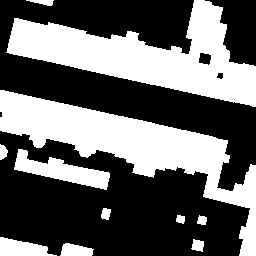

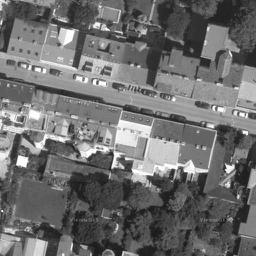

<tf.Tensor: id=107, shape=(256, 256, 1), dtype=int32, numpy=
array([[[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       ...,

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]]])>

<tf.Tensor: id=103, shape=(256, 256, 1), dtype=float32, numpy=
array([[[218.00002  ],
        [ 38.       ],
        [ 43.       ],
        ...,
        [ 38.       ],
        [ 38.       ],
        [ 40.       ]],

       [[176.       ],
        [  3.0000002],
        [ 55.000004 ],
        ...,
        [ 41.       ],
        [ 38.       ],
        [ 37.       ]],

       [[ 27.000002 ],
        [ 49.000004 ],
        [ 59.000004 ],
        ...,
        [ 47.       ],
        [ 46.       ],
        [ 42.       ]],

       ...,

       [[236.00002  ],
        [235.00002  ],
        [235.00002  ],
        ...,
        [239.00002  ],
        [239.00002  ],
        [239.00002  ]],

       [[236.00002  ],
        [235.00002  ],
        [235.00002  ],
        ...,
        [238.00002  ],
        [239.00002  ],
        [239.00002  ]],

       [[234.00002  ],
        [234.00002  ],
        [234.00002  ],
        ...,
        [238.00002  ],
        [239.00002  ],
        [239.00002  ]]], dtype=

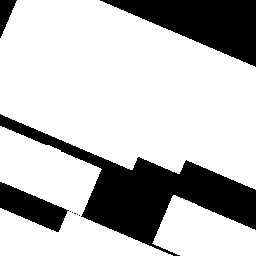

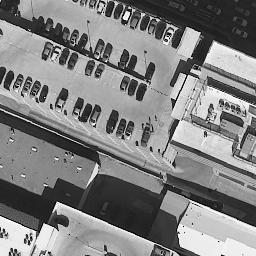

<tf.Tensor: id=127, shape=(256, 256, 1), dtype=int32, numpy=
array([[[  0],
        [  0],
        [  0],
        ...,
        [255],
        [255],
        [255]],

       [[  0],
        [  0],
        [  0],
        ...,
        [255],
        [255],
        [255]],

       [[  0],
        [  0],
        [  0],
        ...,
        [255],
        [255],
        [255]],

       ...,

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]]])>

<tf.Tensor: id=123, shape=(256, 256, 1), dtype=float32, numpy=
array([[[129.      ],
        [124.00001 ],
        [127.00001 ],
        ...,
        [ 73.      ],
        [ 72.      ],
        [ 63.000004]],

       [[133.      ],
        [126.00001 ],
        [129.      ],
        ...,
        [121.00001 ],
        [110.00001 ],
        [115.00001 ]],

       [[128.      ],
        [128.      ],
        [130.      ],
        ...,
        [110.00001 ],
        [111.00001 ],
        [107.00001 ]],

       ...,

       [[178.      ],
        [172.      ],
        [168.      ],
        ...,
        [115.00001 ],
        [108.00001 ],
        [108.00001 ]],

       [[169.      ],
        [176.      ],
        [183.      ],
        ...,
        [113.00001 ],
        [112.00001 ],
        [112.00001 ]],

       [[176.      ],
        [177.      ],
        [181.      ],
        ...,
        [105.00001 ],
        [110.00001 ],
        [110.00001 ]]], dtype=float32)>

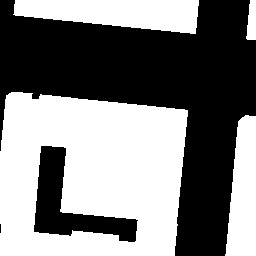

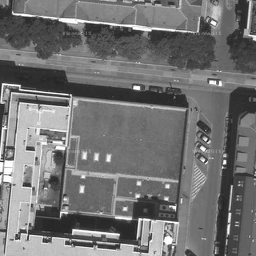

In [7]:
from PIL import Image

iterator = iter(train_dataset)
for _ in range(3):
    augmented_img, target = next(iterator)
    augmented_img = augmented_img[3] 
    augmented_img = augmented_img * 255 
    target = target[3] 
    target
    augmented_img
    
    data = np.zeros((256, 256, 3), dtype=np.uint8)
    data[0:256, 0:256] = augmented_img[0:256, 0:256]
    img = Image.fromarray(data, 'RGB')
    
    tg = np.zeros((256, 256, 3), dtype=np.uint8)
    tg[0:256, 0:256] = target[0:256, 0:256]
    tg_img = Image.fromarray(tg)
    display(tg_img, img)

## Actual CNN 

### Create model

In [8]:
def create_model(depth, start_f, num_classes, dynamic_input_shape):

    model = tf.keras.Sequential()
    
    # Encoder
    for i in range(depth):
        
        if i == 0:
            if dynamic_input_shape:
                input_shape = [None, None, 1]
            else:
                input_shape = [img_h, img_w, 1]
        else:
            input_shape=[None]
        
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2

    # Decoder
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f // 2,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))

        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='sigmoid'))
    
    return model

In [9]:
model = create_model(depth=4, 
                     start_f=4, 
                     num_classes=2, 
                     dynamic_input_shape=False)



In [10]:
%%script false

# Visualize created model as a table
model.summary()

# Visualize initialized weights
model.weights

Couldn't find program: 'false'


In [11]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
def my_IoU(y_pred,y_true):
    # from pobability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax

    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

metrics = [my_IoU]

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'challenge_1')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN_challenge2'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  
callbacks.append(tb_callback)

# Early Stopping
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)

model.fit(x=train_dataset,
          epochs=10,
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen),
          callbacks=callbacks)

Train for 1530 steps, validate for 383 steps
Epoch 1/10
1530/1530 [==============================] - 45s 30ms/step - loss: nan - my_IoU: 0.3654 - val_loss: nan - val_my_IoU: 0.3697
Epoch 2/10
   5/1530 [..............................] - ETA: 42s - loss: nan - my_IoU: 0.3997

C:\Users\Roncax\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


 350/1530 [=====>........................] - ETA: 33s - loss: nan - my_IoU: 0.3640

KeyboardInterrupt: 

In [ ]:
prediction = model.predict_generator(test_img_gen,
                                    verbose=1)

In [ ]:
def rle_encode(img):
      # Flatten column-wise
      pixels = img.T.flatten()
      pixels = np.concatenate([[0], pixels, [0]])
      runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
      runs[1::2] -= runs[::2]
      return ' '.join(str(x) for x in runs)

In [ ]:
# prediction.shape
# print(prediction[1])

iterator = iter(prediction)
for _ in range(prediction.shape[0]):
    pred = next(iterator)
    pred = pred[3] 
    rle_encode(prediction[0])

    
    data = np.zeros((256, 256, 3), dtype=np.uint8)
    data[0:256, 0:256] = pred[0:256, 0:256]
    img = Image.fromarray(data)
    

    display(img)

In [ ]:
### Encode prediction (run-length encoded)